### Version 3: Saves data to a CSV for counting green space pixels of multiple plants in 1 image

In [1]:
# only needed in Jupyter Lab to see the images inline
%matplotlib widget

from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs
import matplotlib.pyplot as plt
import pandas as pd
import os

print("PlantCV Version:", pcv.__version__)

PlantCV Version: 4.9


In [2]:
# Input/output options
args = WorkflowInputs(
    images=["/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/Jupyter_Lab/Max_Work/Version2/test_image.jpg"], # change to where the image will be
    names="image1",
    result="example_results.json",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

csv_path = "/Users/maxwellrosen/Storage/Salk_Plant_Imaging/eckerlabproj/Jupyter_Lab/Max_Work/Version3/analysis_log.csv"

In [3]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

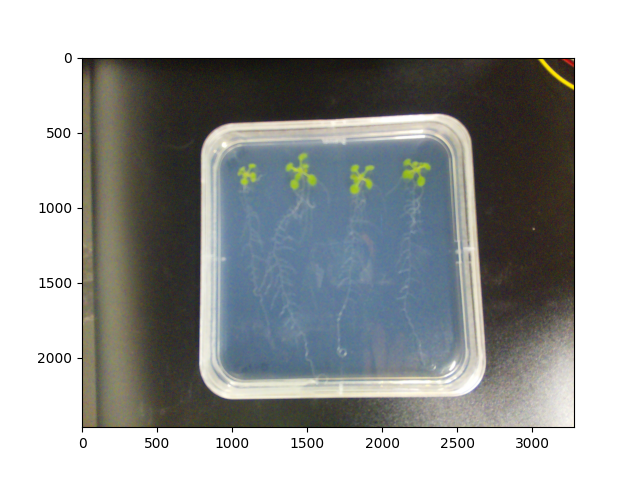

In [4]:
# Shows your image, defines it as "img"
img, path, filename = pcv.readimage(filename=args.image1)

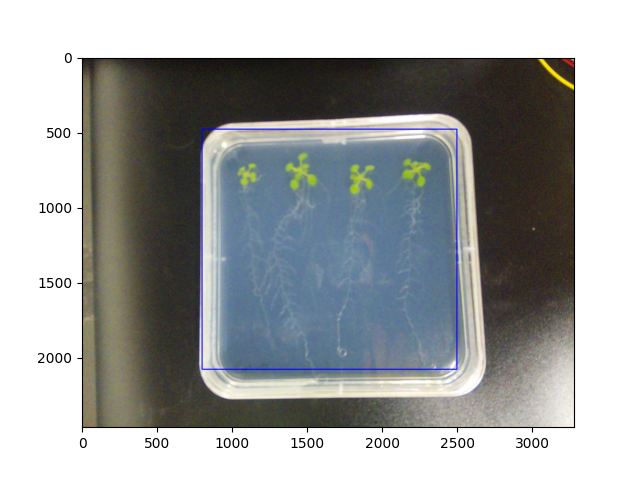

In [5]:
# Crops your image
crop_img = pcv.crop(img=img, x=800, y=480, h=1600, w=1700)

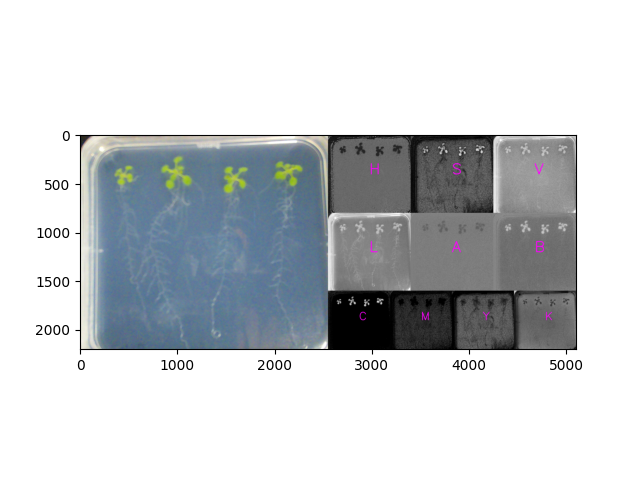

In [6]:
# Shows options for which channel to view the image through (ideally want the most contrast)
colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

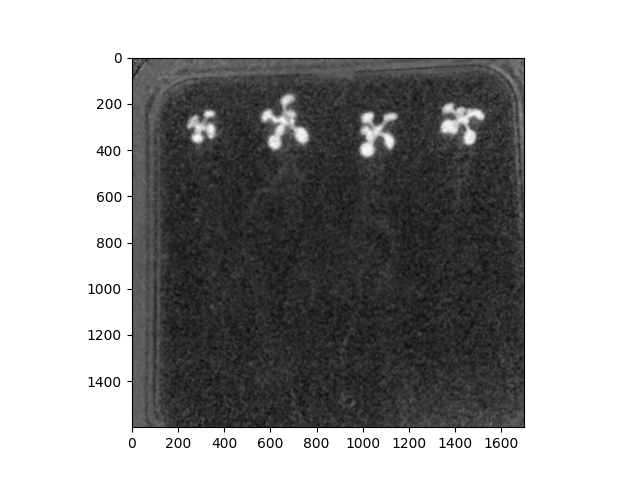

In [7]:
# Actually picks a channel with rgb2gray_"lab" and then the channel is the letter from "lab" that you look through
b_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='b')

In [8]:
# Visualization only, not needed for analysis
hist_figure1, hist_data1 = pcv.visualize.histogram(img = b_img, hist_data=True)

alt.Chart(...)

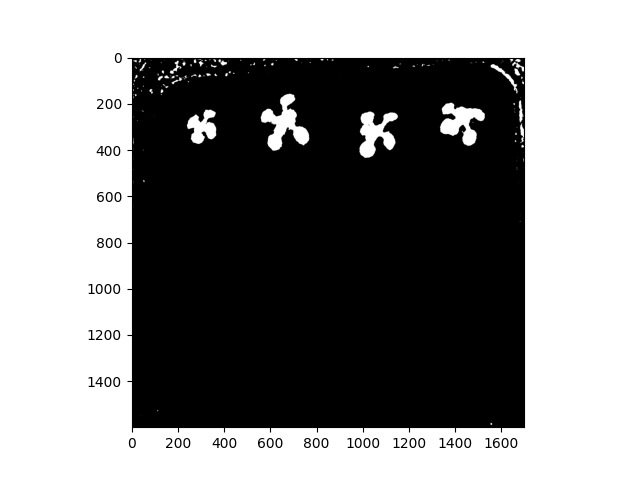

In [9]:
# Masks the image
thresh_mask = pcv.threshold.binary(gray_img=b_img, threshold=140, object_type='light')

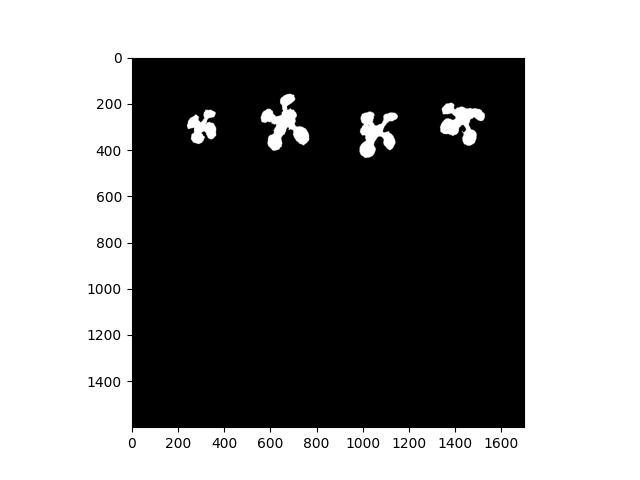

In [10]:
# Deletes groups of pixels less than the pixel size (weird dots around edges not plant is unmasked)
cleaned_mask = pcv.fill(bin_img=thresh_mask, size=3000)

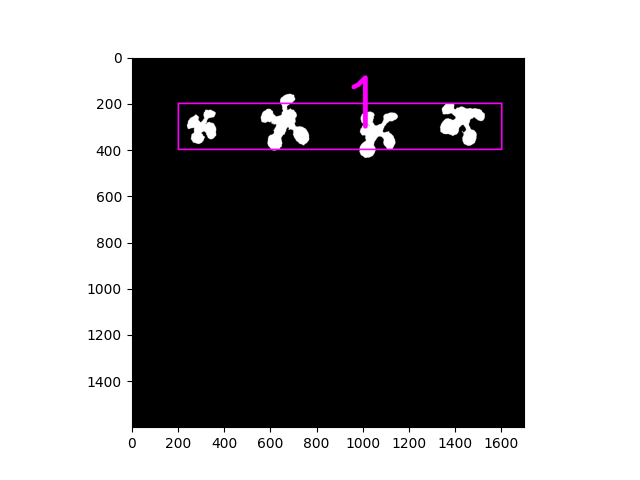

In [11]:
# Defines Region of Interest (ROI) which selects white pixels and deselects black pixels from a masked image
roi = pcv.roi.rectangle(img=cleaned_mask, x=200, y=200, h=200, w=1400)

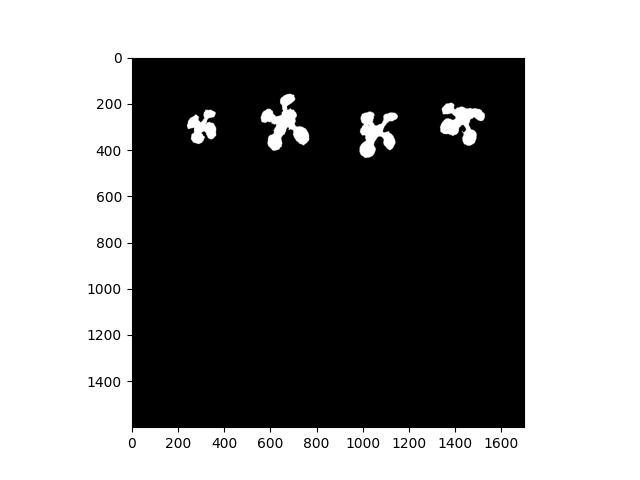

In [12]:
# Makes a new mask only with plants inside ROI

# Inputs for the filtering function:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI then still keeps whole plant if some lies outside ROI), 'cutto' (hard cut off), or 
#                     'largest' (keep only largest object)

kept_mask  = pcv.roi.quick_filter(mask=cleaned_mask, roi=roi)

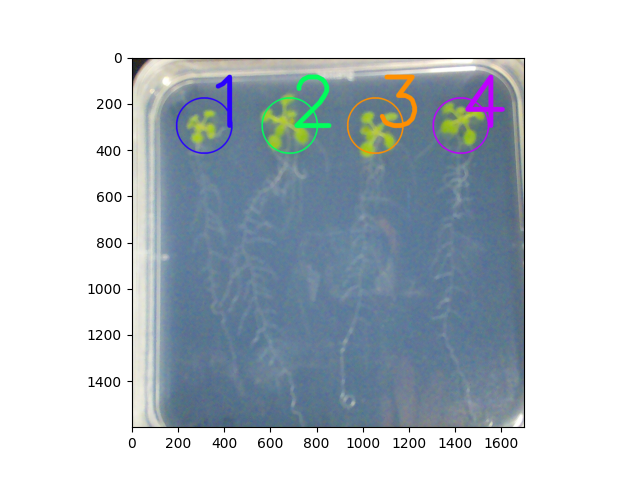

In [13]:
# Make new ROI's to select the different plants (use/change this for rows and columns of plants)
auto_rois = pcv.roi.auto_grid(mask=kept_mask, nrows=1, ncols=4, img=crop_img)

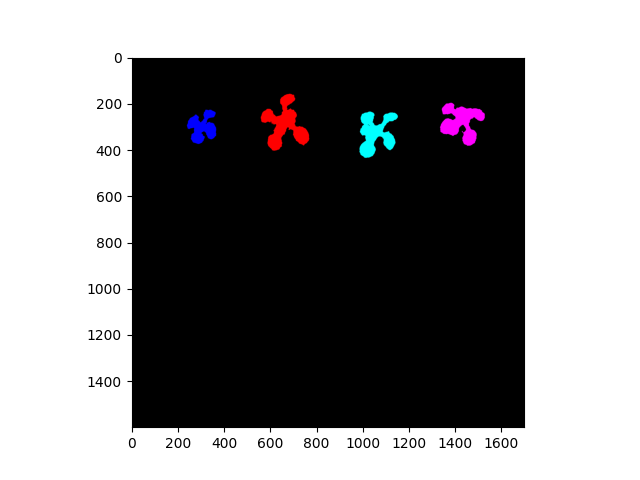

In [14]:
# Label and number objects in ROI; A good check to ensure different plants are different objects from being different colors
labeled_mask, num_plants = pcv.create_labels(mask=kept_mask, rois=auto_rois, roi_type='partial')

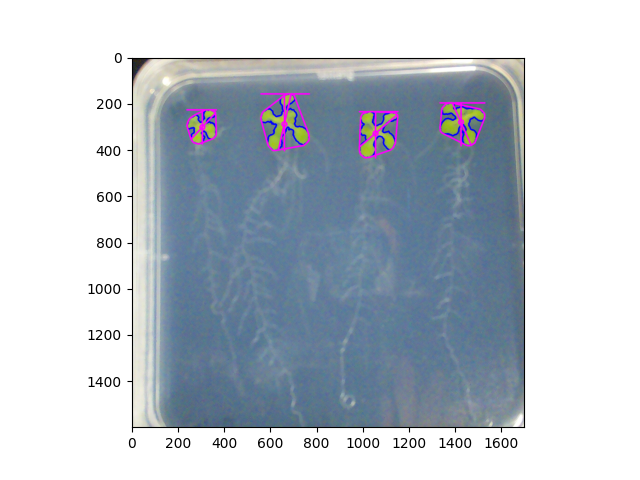

In [21]:
# Outputs analyzed image
shape_image = pcv.analyze.size(img=crop_img, labeled_mask=labeled_mask, n_labels=num_plants)

In [22]:
# Makes histogram of colors inside ROI
color_histogram = pcv.analyze.color(rgb_img=crop_img, labeled_mask=kept_mask, colorspaces='all', label="default")

alt.FacetChart(...)

In [17]:
# Saves results for the 1 image (running again overwites past results)
pcv.outputs.save_results(filename= args.result, outformat="json")

In [18]:
# Prints how many pixels were counted
for i in range(4):
    i = i+1
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    pixels_label = pcv.outputs.observations[f"default_{i}"]["area"]["label"]
    print(f"Number of pixels for plant{i}:", pixels_value, pixels_label)

Number of pixels for plant1: 11077.0 pixels
Number of pixels for plant2: 21673.0 pixels
Number of pixels for plant3: 18164.0 pixels
Number of pixels for plant4: 18480.0 pixels


In [19]:
# Create single-row DataFrame and 
for i in range(4):
    i = i+1
    pixels_value = pcv.outputs.observations[f"default_{i}"]["area"]["value"]
    pixels_label = pcv.outputs.observations[f"default_{i}"]["area"]["label"]
    new_data = pd.DataFrame([{
        "image_name": f"plant{i}", #need to universalize image names (with specific ID's?)
        "area in pixels": pixels_value
    }])
    # If analysis_log.csv doesn't exist, creates it with a header:
    if not os.path.isfile(csv_path):
        new_data.to_csv(csv_path, index=False)
    else:
        # Append without writing header again
        new_data.to_csv(csv_path, mode='a', header=False, index=False)

In [20]:
plt.close('all')